In [1]:
%matplotlib inline
import jax
import jax.numpy as jnp
import jax.experimental.optimizers
import matplotlib.pyplot as plt

### training data 

In [2]:
def sphere_points(samples):
    # generate the points of a Fibonnaci sphere

    # empty arrays to fill (jax numpy arrays are immuable, hence the use of standard numpy):
    from numpy import empty, uint8
    points = empty((samples, 3))
    phi = jnp.pi * (3.0 - jnp.sqrt(5.0))  # golden angle in radians

    for i in range(samples):
        y = 1.0 - (i / float(samples - 1)) * 2.0  # y goes from 1 to -1
        radius = jnp.sqrt(1.0 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = jnp.cos(theta) * radius
        z = jnp.sin(theta) * radius

        points[i] = (x, y, z)

    return points

def norm(x):
  return 2.0 * (x - x.min()) / (x.max() - x.min()) - 1.0

N_train_data = 1024
train_data = norm(sphere_points(N_train_data))

print(f'train data shape:\t{train_data.shape}')

train data shape:	(1024, 3)


### plotting

In [3]:
def plot_points(ax, points, c):
  # plot a sphere on a figure's axis.
  ax.scatter(points[:,0], 
             points[:,1], 
             points[:,2], 
             color=c)
  ax.axis('off')
  ax.dist = 6

def plot_axes(ax):
  # plot our x, y, z axis lines for perspective
  line = [-1.3, 1.3]
  zeros = [0.0, 0.0]
  ax.plot(line, zeros, zeros, color='k')
  ax.plot(zeros, line, zeros, color='k')
  ax.plot(zeros, zeros, line, color='k')

def plot_3d(generated_points):
  fig = plt.figure(figsize=(6.5,3.0), dpi=100)

  ax1 = fig.add_subplot(121, projection='3d')
  ax1.set_title('training', y=1.05)
  plot_axes(ax1)
  plot_points(ax1, train_data, 'firebrick')
  
  ax2 = fig.add_subplot(122, projection='3d')
  ax2.set_title('generated', y=1.05)
  plot_axes(ax2)
  plot_points(ax2, generated_points, 'rebeccapurple')

### PRNG key


In [4]:
prng = jax.random.PRNGKey(42)

### discriminator and generator models

#### discriminator

In [5]:
num_hidden1 = 512
num_hidden2 = 256

(prng, w1key, b1key, w2key, 
       b2key, w3key, b3key) = jax.random.split(prng, 7)

def D_build_params():
  dw = 0.001
  params = dict(
      w1 = dw * jax.random.normal(w1key, (3, num_hidden1)),
      b1 = dw * jax.random.normal(b1key, (1, num_hidden1)),
      w2 = dw * jax.random.normal(w2key, (num_hidden1, num_hidden2)),
      b2 = dw * jax.random.normal(b2key, (1, num_hidden2)),
      w3 = dw * jax.random.normal(w3key, (num_hidden2, 1)),
      b3 = dw * jax.random.normal(b3key, (1, 1)),
  )
  return params

@jax.jit
def D_forward(params, x):
  # 3 layer dense network
  x = jax.nn.relu(x @ params["w1"] + params["b1"])
  x = jax.nn.relu(x @ params["w2"] + params["b2"])
  x = x @ params["w3"] + params["b3"]
  return jax.nn.sigmoid(x)

#### generator

In [6]:
(prng, w1key, b1key, w2key, 
       b2key, w3key, b3key) = jax.random.split(prng, 7)

def G_build_params():
  dw = 0.001
  params = dict(
      w1 = dw * jax.random.normal(w1key, (3, num_hidden1)),
      b1 = dw * jax.random.normal(b1key, (1, num_hidden1)),
      w2 = dw * jax.random.normal(w2key, (num_hidden1, num_hidden2)),
      b2 = dw * jax.random.normal(b2key, (1, num_hidden2)),
      w3 = dw * jax.random.normal(w3key, (num_hidden2, 3)),
      b3 = dw * jax.random.normal(b3key, (1, 3)),
  )
  return params

# @jax.jit
def G_sample_latent_space(N, key):
  # batch of 3 latent points: don't sample the same random number
  # _key = jax.random.PRNGKey(*np.random.randint(0, 100, 1)) # this is terrible...
  # z = jax.random.normal(_key, (N, 3))
  z = jax.random.normal(key, (N, 3))
  return z

@jax.jit
def G_forward(params, key):
  # 3 layer dense network
  z = G_sample_latent_space(batch_size, key)
  x = jax.nn.relu(z @ params["w1"] + params["b1"])
  x = jax.nn.relu(x @ params["w2"] + params["b2"])
  x = x @ params["w3"] + params["b3"]
  return jax.nn.hard_tanh(x)

def G_generate(params, key, Ngen):
  # generating samples after training
  z = G_sample_latent_space(Ngen, key)
  x = jax.nn.relu(z @ params["w1"] + params["b1"])
  x = jax.nn.relu(x @ params["w2"] + params["b2"])
  x = x @ params["w3"] + params["b3"]
  return jax.nn.hard_tanh(x)

### training 

#### losses and accuracy

In [7]:
@jax.jit   
def bce_loss(x, y):
    # BCE loss - used in GANs.
    # out = D_forward(params, x)
    def bce(x, y):
      _bce_loss =  -1.0 * y * jnp.log(x) - (1.0 - y) * jnp.log(1.0 - x)
      return _bce_loss

    _element_loss = jax.vmap(lambda x, y: bce(x, y))
    return _element_loss(x, y).mean()

@jax.jit
def lossforward(params, x, y):
    # x data, y = decision
    x = D_forward(params, x)
    loss = bce_loss(x, y) #xeloss(x, y) # cross-entropy
    return loss

@jax.jit
def accuracy(x, y):
    return 100.0 * (jnp.argmax(x, 1) == y).mean()

#### optimizer

In [8]:
# optimizer
learning_rate = 0.001

D_params = D_build_params()
G_params = G_build_params()

def build_optim(params, learning_rate):
  (optim_init, 
   optim_update,
   optim_params) = jax.experimental.optimizers.adam(learning_rate)
  optim_state = optim_init(params)
  return (optim_init, optim_update, optim_params, optim_state)

D_optim_init, D_optim_update, \
 D_optim_params, D_optim_state = build_optim(D_params, learning_rate)
G_optim_init, G_optim_update, \
 G_optim_params, G_optim_state = build_optim(G_params, learning_rate)

#### train_steps

In [9]:
@jax.jit
def D_train_step(step, params, optim_state, x, y):
    params = D_optim_params(optim_state)
    loss, grads = jax.value_and_grad(lossforward)(params, x, y)
    optim_state = D_optim_update(step, grads, optim_state)
    return loss, optim_state

@jax.jit
def G_train_step(step, params, optim_state, x, y):
    params = G_optim_params(optim_state)
    # loss forward does D(x), also pass y as decisions
    loss, grads = jax.value_and_grad(lossforward)(params, x, y)
    optim_state = G_optim_update(step, grads, optim_state)
    return loss, optim_state

### training loop

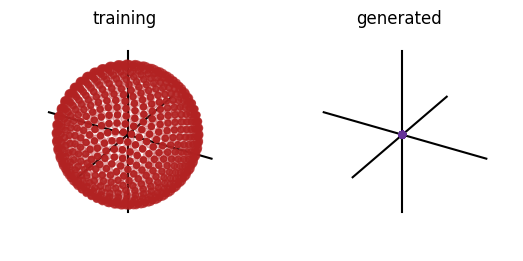

In [10]:
prng, key = jax.random.split(prng)
generated = G_generate(G_params, key, N_train_data)
plot_3d(generated)

In [11]:
D_history, G_history = [], []
batch_size = 100
num_steps = 2000

for step in range(num_steps):

    prng, key = jax.random.split(prng)
    idxs = jax.random.randint(key, (batch_size,), 0, N_train_data)

    # train discriminator 
    x = jnp.concatenate((train_data[idxs], G_forward(G_params, key)))
    y = jnp.concatenate((jnp.ones((batch_size,)), jnp.zeros((batch_size,)))) # jnp.int8 for both         
    D_loss, D_optim_state = D_train_step(step, D_params, D_optim_state, x, y)

    # train generator (dont update discriminator params, no optim state for D)
    x = G_forward(G_params, key)
    y = jnp.ones((batch_size,)) # the lie 
    G_loss, G_optim_state = G_train_step(step, G_params, G_optim_state, x, y) 

    D_history.append(D_loss)
    G_history.append(G_loss)

    if step % 100 == 0:
      print(f"Step {step:05.0f} \t D = {D_loss:5.5E} \t G = {G_loss:5.5E}")

Step 00000 	 D = 6.93147E-01 	 G = 6.92854E-01
Step 00100 	 D = 5.89598E-03 	 G = 1.10623E-03
Step 00200 	 D = 8.14690E-04 	 G = 1.49857E-04
Step 00300 	 D = 3.14945E-04 	 G = 4.44661E-05
Step 00400 	 D = 1.59638E-04 	 G = 2.10208E-05
Step 00500 	 D = 9.51894E-05 	 G = 1.22389E-05
Step 00600 	 D = 6.27808E-05 	 G = 8.02679E-06
Step 00700 	 D = 4.38653E-05 	 G = 5.64259E-06
Step 00800 	 D = 3.23412E-05 	 G = 4.21207E-06
Step 00900 	 D = 2.46625E-05 	 G = 3.21866E-06
Step 01000 	 D = 1.99983E-05 	 G = 2.54313E-06
Step 01100 	 D = 1.56691E-05 	 G = 2.06630E-06
Step 01200 	 D =   NAN 	 G = 1.70867E-06
Step 01300 	 D =   NAN 	 G = 1.43051E-06
Step 01400 	 D =   NAN 	 G = 1.19209E-06
Step 01500 	 D =   NAN 	 G = 1.07288E-06
Step 01600 	 D =   NAN 	 G = 9.53675E-07
Step 01700 	 D =   NAN 	 G = 8.34465E-07
Step 01800 	 D =   NAN 	 G = 7.15256E-07
Step 01900 	 D =   NAN 	 G = 5.96047E-07


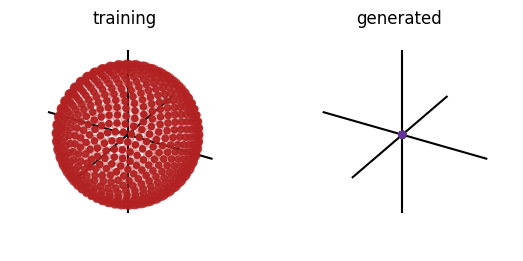

In [12]:
generated = G_generate(G_params, key, N_train_data)
plot_3d(generated)

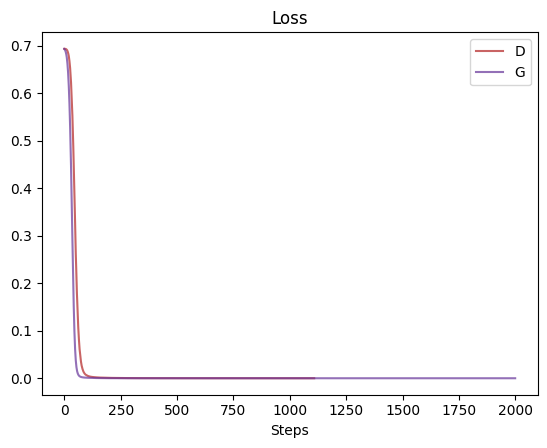

In [13]:
fig, ax_loss = plt.subplots(figsize=(6.4, 4.8), dpi=100)

plt.plot(range(num_steps), D_history, '-', 
         color='firebrick', label='D', alpha=0.7)
plt.plot(range(num_steps), G_history, '-', 
         color='rebeccapurple', label='G', alpha=0.7)
plt.legend(loc='best')
plt.xlabel('Steps')
plt.title('Loss')
plt.show()